<table>
    <tr>
        <td><img src="./img/Macc.png" width="auto"/></td>
        <td>
            <table><tr>
            <h1 style="color:blue;text-align:center">Lógica para Ciencias de la Computación</h1></td>
            </tr></table>   
        <td>&nbsp;</td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Taller</p></tp>
            <tp><p style="font-size:150%;text-align:center">Transformación de Tseitin</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

# Objetivos <a class="anchor" id="inicio"></a>

El objetivo de este notebook es implementar el algoritmo de transformación de Tseitin, el cual toma una fórmula arbitraria $A$ de la lógica proposicional y produce una fórmula $B$ en forma normal conjuntiva (FNC) tal que todo modelo de $B$ es un modelo de $A$. Esta transformación corre en tiempo lineal respecto a la longitud de $A$.

Desarrollaremos el tema mediante las siguientes secciones:


# Secciones

1. [Transformación a FNC.](#inef)
2. [Forma clausal en Python.](#clausal)
3. [Transformación de Tseitin.](#tseitin)
4. [Comparación de tiempos.](#comp)


# Transformación a FNC <a class="anchor" id="inef"></a>

([Volver al inicio](#inicio))

En clases anteriores hemos visto la FNC y un algoritmo de transformación de una fórmula $A$ a otra fórmula $A'$ que está en FNC y es tal que $A\equiv A'$.

El algoritmo sigue los siguientes pasos:

* Eliminar `$\leftrightarrow$' y '$\to$'.
* Eliminar dobles negaciones.
* Si $\neg(B\wedge C)\in A.\mbox{subform}()$, reemplazarla por $\neg B\vee\neg C$.
* Si $\neg(B\vee C)\in A.\mbox{subform}()$, reemplazarla por $\neg B\wedge\neg C$.
* Eliminar dobles negaciones.
* Mientras se pueda realizar la distribución: reemplazar $B\vee (C\wedge D)\in A.\mbox{subform}()$ por $(B\vee C)\wedge (B\vee D)$.

Estos métodos están implementados en la librería `Logica`:

In [1]:
from Logica import *

In [2]:
A = inorder_to_tree("((-pOq)>-(rY-t))")
print(f'Fórmula inicial:\n{str(A)}')
A = A.eliminar_imp()
print(f'Al eliminar las implicaciones se obtiene:\n{str(A)}')
A = A.eliminar_doble_negacion()
print(f'Al eliminar las dobles negaciones se obtiene:\n{str(A)}')
A = A.cambiar_de_morgan_y()
print(f'Al reemplazar -(AYB) por -AO-B se obtiene:\n{str(A)}')
A = A.cambiar_de_morgan_o()
print(f'Al reemplazar -(AOB) por -AY-B se obtiene:\n{str(A)}')
A = A.eliminar_doble_negacion()
print(f'Al eliminar las dobles negaciones se obtiene:\n{str(A)}')
A = A.distribuir_o_en_y()
print(f'Al distribuir O en Y se obtiene:\n{str(A)}')

Fórmula inicial:
((-pOq)>-(rY-t))
Al eliminar las implicaciones se obtiene:
(-(-pOq)O-(rY-t))
Al eliminar las dobles negaciones se obtiene:
(-(-pOq)O-(rY-t))
Al reemplazar -(AYB) por -AO-B se obtiene:
(-(-pOq)O(-rO--t))
Al reemplazar -(AOB) por -AY-B se obtiene:
((--pY-q)O(-rO--t))
Al eliminar las dobles negaciones se obtiene:
((pY-q)O(-rOt))
Al distribuir O en Y se obtiene:
((pO(-rOt))Y(-qO(-rOt)))


Este proceso se implementó también en el método `fnc`:

In [3]:
A = inorder_to_tree("((-pOq)>-(rY-t))")
print(A.fnc())

((pO(-rOt))Y(-qO(-rOt)))


Podemos medir los tiempos de ejecución de la transformación sobre fórmulas aleatorias de longitud cada vez mayor:

In [4]:
from Tiempos import *

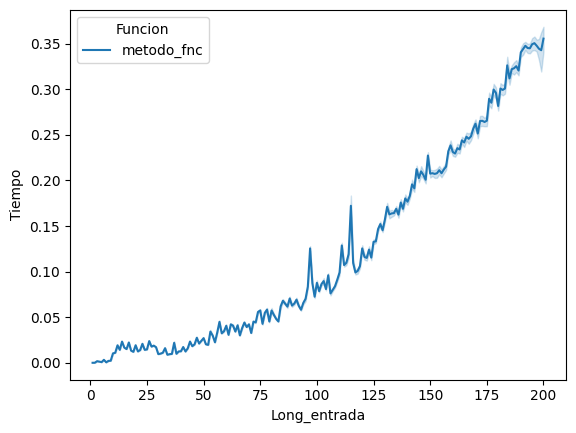

In [5]:
lista = lista_formulas(cantidad=200, tipo='aleatorio')
nombres = ['metodo_fnc']
metodo_fnc = lambda formula: inorder_to_tree(formula).fnc()
funs = [metodo_fnc]
compara_entradas_funs(funs, nombres, lista)

No obstante, dado que no hay una función con la cual comparar los tiempos de ejecución de esta transformación, no podemos ver claramente qué tan eficiente es. Una manera de darnos cuenta de que necesitamos un algoritmo más eficiente de transformación es tratando de transformar una fórmula con 1000 conectivos:

In [8]:
%%time
lista = lista_formulas(cantidad=1000, tipo='aleatorio')
A = inorder_to_tree(lista[-1])
A.fnc()

CPU times: user 461 ms, sys: 9.1 ms, total: 470 ms
Wall time: 670 ms


Es posible que al compilar la celda anterior haya ocurrido un error como 

`RecursionError: maximum recursion depth exceeded while calling a Python object`

Para obtener una representación más eficiente, que no dependa del límite de recursión, vamos a usar la forma clausal de las fórmulas.

---

# Forma clausal <a class="anchor" id="clausal"></a>

([Volver al inicio](#inicio))

La forma clausal es una variación notacional para las fórmulas en FNC:

* Los literales negativos, digamos $\neg p$, se denotan como $\overline{p}$.
* Las cláusulas, digamos $p\vee\neg q\vee r$, se denotan como secuencias de literales, es decir, $p\overline{q}r$.
* Convención: La cláusula vacía (es decir, la secuencia vacía de literales) se denota por $\Box$.
* Una conjunción de cláusulas, digamos $(p\vee q)\wedge (r\vee\neg p)$ se denota como un conjunto de cláusulas, es decir, $\{pq, r\overline{p}\}$.
* Convención: El conjunto vacío de cláusulas se denota por $\emptyset$ y es distinto de $\Box$, (pues podemos considerar $\{\Box\})$.

En Python representaremos una fórmula en forma clausal como una lista de listas de literales. Por ejemplo:

$(p\vee q)\wedge (r\vee\neg p)$ se denota como $\{pq, r\overline{p}\}$ y en Python:

In [11]:
A = [['p','q'], ['r', '-p']]

Aún no tenemos un método para operar fórmulas en esta representación, como si ocurre en la representación de fórmulas mediante árboles. Sin embargo, en la próxima clase veremos un SATsolver eficiente para buscar modelos de fórmulas, llamado el algoritmo DPLL, el cual opera sobre fórmulas en forma clausal.

Antes de ver este algoritmo, debemos implementar una manera eficiente de transformar una fórmula en su representación clausal. Esto lo haremos en la siguiente sección mediante la transformación de Tseitin. Lo que debemos hacer en este momento es entender el procedimiento de transformar equivalencias de la forma $p\leftrightarrow \neg q$ en su representación clausal, el cuál usaremos para hacer Tseitin. 

Recordemos aquí las equivalencias útiles en Forma Clausal:

1. $p\leftrightarrow \neg q \quad \equiv \quad \{\overline{p}\ \overline{q}, pq\}$
2. $p\leftrightarrow (q\wedge r) \quad \equiv \quad \{q\overline{p}, r\overline{p}, \overline{q}\overline{r}p\}$
3. $p\leftrightarrow (q\vee r) \quad \equiv \quad \{\overline{q}p, \overline{r}p, qr\overline{p}\}$
4. $p\leftrightarrow (q\to r) \quad \equiv \quad \{qp, \overline{r}p, \overline{q}r\overline{p}\}$

Mediante el siguiente código se implementa esta equivalencia:

In [12]:
def a_clausal(A):
    # Subrutina de Tseitin para encontrar la FNC de
    # la formula en la pila
    # Input: A (cadena) de la forma
    #                   p=-q
    #                   p=(qYr)
    #                   p=(qOr)
    #                   p=(q>r)
    # Output: B (cadena), equivalente en FNC
    assert(len(A)==4 or len(A)==7), u"Fórmula incorrecta!"
    B = ''
    p = A[0]
    # print('p', p)
    if "-" in A:
        q = A[-1]
        # print('q', q)
        B = "-"+p+"O-"+q+"Y"+p+"O"+q
    elif "Y" in A:
        q = A[3]
        # print('q', q)
        r = A[5]
        # print('r', r)
        B = q+"O-"+p+"Y"+r+"O-"+p+"Y-"+q+"O-"+r+"O"+p
    elif "O" in A:
        q = A[3]
        # print('q', q)
        r = A[5]
        # print('r', r)
        B = "-"+q+"O"+p+"Y-"+r+"O"+p+"Y"+q+"O"+r+"O-"+p
    elif ">" in A:
        q = A[3]
        # print('q', q)
        r = A[5]
        # print('r', r)
        B = q+"O"+p+"Y-"+r+"O"+p+"Y-"+q+"O"+r+"O-"+p
    elif "=" in A:
        q = A[3]
        # print('q', q)
        r = A[5]
        # print('r', r)
        #qO-rO-pY-qOrO-pY-qO-rOpYqOrOp
        B = q+"O"+"-"+r+"O"+"-"+p+"Y"+"-"+q+"O"+r+"O"+"-"+p+"Y"+"-"+q+"O"+"-"+r+"O"+p+"Y"+q+"O"+r+"O"+p
    else:
        print(u'Error enENC(): Fórmula incorrecta!')
    B = B.split('Y')
    B = [c.split('O') for c in B]
    return B

Observe el funcionamiento de esta función sobre el primer ejemplo de equivalencias útiles:

$$p\leftrightarrow \neg q \quad \equiv \quad \{\overline{p}\ \overline{q}, pq\}$$

In [13]:
A = 'p=-q'
print('p=-q', 'se representa por', a_clausal(A))

p=-q se representa por [['-p', '-q'], ['p', 'q']]


Esta función sólo se aplica sobre las cuatro equivalencias útiles.

**Ejercicio 1:**

Compruebe el funcionamiento de `a_clausal` en las equivalencias 2, 3 y 4.

2. $p\leftrightarrow (q\wedge r) \quad \equiv \quad \{q\overline{p}, r\overline{p}, \overline{q}\overline{r}p\}$
3. $p\leftrightarrow (q\vee r) \quad \equiv \quad \{\overline{q}p, \overline{r}p, qr\overline{p}\}$
4. $p\leftrightarrow (q\to r) \quad \equiv \quad \{qp, \overline{r}p, \overline{q}r\overline{p}\}$

---

# Transformación de Tseitin <a class="anchor" id="tseitin"></a>

([Volver al inicio](#inicio))

La transformación de Tseitin de una fórmula $A$ es una fórmula $B$ en forma clausal tal que todo modelo de $B$ es un modelo de $A$.

El siguiente es el código que implementa esta transformación:

In [14]:
def tseitin(A):
    '''
    Algoritmo de transformacion de Tseitin
    Input: A (cadena) en notacion inorder
    Output: B (cadena), Tseitin
    '''
    # Creamos letras proposicionales nuevas
    f = inorder_to_tree(A)
    letrasp = f.letras()
    cods_letras = [ord(x) for x in letrasp]
    m = max(cods_letras) + 256
    letrasp_tseitin = [chr(x) for x in range(m, m + f.num_conec())]
    letrasp = list(letrasp) + letrasp_tseitin
    L = [] # Inicializamos lista de conjunciones
    Pila = [] # Inicializamos pila
    i = -1 # Inicializamos contador de variables nuevas
    s = A[0] # Inicializamos símbolo de trabajo
    while len(A) > 0: # Recorremos la cadena
        # print("Pila:", Pila, " L:", L, " s:", s)
        if (s in letrasp) and (len(Pila) > 0) and (Pila[-1]=='-'):
            i += 1
            atomo = letrasp_tseitin[i]
            Pila = Pila[:-1]
            Pila.append(atomo)
            L.append(atomo + "=-" + s)
            A = A[1:]
            if len(A) > 0:
                s = A[0]
        elif s == ')':
            w = Pila[-1]
            O = Pila[-2]
            v = Pila[-3]
            Pila = Pila[:len(Pila)-4]
            i += 1
            atomo = letrasp_tseitin[i]
            L.append(atomo + "=(" + v + O + w + ")")
            s = atomo
        else:
            Pila.append(s)
            A = A[1:]
            if len(A) > 0:
                s = A[0]
    if i < 0:
        atomo = Pila[-1]
    else:
        atomo = letrasp_tseitin[i]
    B = [[atomo]] + [a_clausal(x) for x in L]
    return B


Observe el funcionamiento de `tseitin` en la primera equivalencia. Se tiene que $\neg q$ se corresponde con la fórmula $x_1\wedge x_1\leftrightarrow\neg q$, la cual tiene como representación en forma clausal el conjunto $\{x_1, \overline{x_1}\ \overline{q}, x_1q\}$. En resumen:

$$\neg q \mbox{ se transforma en } \{x_1, \overline{x_1}\ \overline{q}, x_1q\}$$

In [15]:
A = "-q"
print(A, 'se transforma en\n', tseitin(A))

-q se transforma en
 [['ű'], [['-ű', '-q'], ['ű', 'q']]]


**Ejercicio 2:**

Compruebe el funcionamiento de `tseitin` sobre los conectivos $\wedge$, $\vee$ y $\to$:

2. $(q\wedge r)$ se transforma en $\{x_1, \overline{x_1}q, \overline{x_1}r, \overline{q}\overline{r}x_1\}$
3. $(q\vee r)$ se transforma en $\{x_1, x_1\overline{q}, x_1\overline{r}, qr\overline{x_1}\}$
4. $(q\to r)$ se transforma en $\{x_1, x_1q, x_1\overline{r}, \overline{q}r\overline{x_1}\}$

In [16]:
A = '(qYr)'
print(A, "se transforma en\n", tseitin(A))

(qYr) se transforma en
 [['Ų'], [['q', '-Ų'], ['r', '-Ų'], ['-q', '-r', 'Ų']]]


# Comparación de tiempos <a class="anchor" id="comp"></a>

([Volver al inicio](#inicio))

Y ahora lo prometido. Debemos ver que la transformación de Tseitin es un algoritmo eficiente, es decir, que el aumento de tiempo de ejecución está en proporción lineal con la longitud de la fórmula:

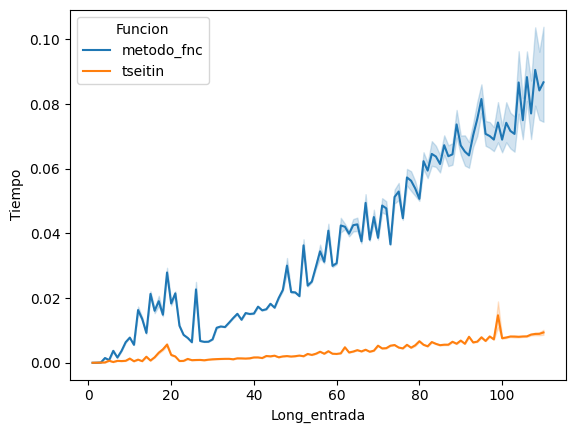

In [19]:
lista = lista_formulas(cantidad=110, tipo='aleatorio')
nombres = ['metodo_fnc', 'tseitin']
metodo_fnc = lambda formula: inorder_to_tree(formula).fnc()
funs = [metodo_fnc, tseitin]
compara_entradas_funs(funs, nombres, lista)

Observe que a medida que aumentamos la longitud de las fórmulas, el método `fnc` es cada vez más demorado. Adicionalmente, es fácil observar que el algoritmo de Tseitin aumenta su tiempo de ejecución de manera lineal con respecto a la longitud de las fórmulas. Este es un resultado realmente extraordinario y útil.

---